# Machine Learning Challenge

Below are 2 data challenges that test for your ability to:
- Wrangle/clean data to make it usable by a model
- Figure out how to set up X's and y's for a use case, given a dataset
- Write code to robustly and reproducibly preprocess data
- Pick/design the right model, and tune hyperparameters to get the best performance

You can use any programming language, model, and package to solve these problems. Let us know of any assumptions you make in your process.

#### Deliverables:
- A link to a github repository that contains:
    - Clearly commented code that was written to solve these problems
    - Your trained models stored in a file (`.pkl`, `.h5`, `.tar` - whatever is appropriate). The models must have `predict(X)` functions. 
    - A readme file that contains:
        - Instructions to easily access/load the above
        - A writeup explaining any significant design decisions and your reasons for making them. 
        - If needed, a brief writeup explaining anything you are particularly proud of in your implementation that you might want us to focus on

#### How we'll assess your work:
- Accuracy/RMSE of your model when predicting on held-out data
- How well various edge cases are handled when testing on held-out data. For example, if the held-out data contains:
    - A new column that wasn't present in the dataset given to you
    - New value in a categorical field that wasn't seen in the dataset given to you
    - NA values
- Efficiency of the code. 
    - Is it easy to understand? 
    - Are the variable names descriptive? 
    - Are there any variables created that aren't used? 
    - Is redundant code replaced with function calls? 
    - Is vectorized implementation used instead of nested for loops? 
    - Are classes defined and objects created where applicable? 
    - Are packages used to perform tasks instead of implementing them from scratch?
    
**NOTE:** Your stored models, once loaded, should *just work* when fed with our held-out data (which looks similar to the data we've given you). We won't do any preprocessing before we feed it into the model's `predict(X)` function; `predict(X)` should handle the preprocessing. Pay particular attention to handling the edge cases we've talked about.

Feel free to ask questions to clarify things. Submit everything you tried, not just the things that worked. I encourage you to try and showcase your talents. The more you go above and beyond what's expected, the more impressed we'll be. **Bonus points if you fit Keras/Tensorflow/Pytorch/Caffe models** in addition to your Linear/Tree-based models.

## 0. Import dependencies

In [3]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt


from sklearn import preprocessing as scale
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Functions used in previous models

In [72]:
def preProcess(df):
    """
    Function to preprocess similar datasets: 
    Takes in a dataframe, checks for null values, replaces categorical value columns with dummy variables
    and fills the remaining null values in the numerical columns with the means of that column"""
    
    df.fillna(method='ffill', inplace=True)         #As the data is arranged chronologically, we fill the next missing variable with that of the previous hour/day
    df.fillna(method='bfill', inplace=True)         #Incase some NaNs are at the start
    
    categorical_columns = df.select_dtypes(include=['object'])
    dummy_columns = pd.get_dummies(categorical_columns)
    
    df = pd.concat([df.drop(categorical_columns, axis=1), dummy_columns], axis=1)
    
    return df

In [73]:
def dataSplit(df_X, y, dtype, test_size=0.2):
    """Function to split the training data into training, validation, and testing size and convert target variable to required type"""
    xtrain, xtest, ytrain, ytest = train_test_split(df_X, y, test_size = test_size, random_state = 19)
    
    ytrain, ytest = ytrain.astype(dtype), ytest.astype(dtype)
    return xtrain, xtest, ytrain, ytest

## Task 2
`forecasting_dataset.csv` is a file that contains pollution data for a city. Your task is to create a model that, when fed with columns `co_gt`, `nhmc`, `c6h6`, `s2`, `nox`, `s3`, `no2`, `s4`, `s5`, `t`, `rh`, `ah`, and `level`, predicts the value of `y` six hours later.

**NOTE:** In the data we've given you, the value of `y` for a given row is the value of `y` *for the timestamp of that same row*. We're asking you to predict the value of `y` 6 hours *after the timestamp of that row*.

Initially we follow the same process to prep the data as the last two notebooks

In [74]:
## What the data that we'll feed into your model's predict(X) function will look like:
# Notice what the level column looks like
pd.read_csv("forecasting_dataset.csv").drop(labels=['date', 'time', 'y'], axis='columns').head()

,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,-200.0,-200.0,7.2,867.0,-200.0,834.0,-200.0,1314.0,891.0,14.8,57.3,0.9603,NaN
1,0.5,-200.0,3.9,704.0,-200.0,861.0,-200.0,1603.0,860.0,24.4,65.0,1.9612,Low
2,3.7,-200.0,23.3,1386.0,NaN,626.0,109.0,2138.0,NaN,23.3,38.6,1.0919,High
3,2.1,-200.0,12.1,1052.0,183.0,779.0,NaN,1690.0,952.0,28.5,27.3,1.0479,High
4,4.4,-200.0,21.7,1342.0,786.0,499.0,206.0,1546.0,2006.0,12.9,54.1,0.8003,High


In [75]:
df = pd.read_csv("forecasting_dataset.csv", parse_dates=[['date','time']]).sort_values(by = ['date_time'])


In [76]:
df = preProcess(df.drop(['date_time'], axis =1))


In [77]:
df['y_6_hours_later'] = df.y.shift(-6)
df.dropna(inplace=True)

LSTMS in Keras, however, don't accept pandas dataframes unfortunately. So we move our data over to numpy arrays to perform scaling and transformations.
The MinMax scaler is later recalled after the model is fit, to transform the data back up for predictions.

In [136]:
matrix = df.drop('y', axis=1).values
MinMax = scale.MinMaxScaler(feature_range=[-1,1])
scaled_data = MinMax.fit_transform(matrix)

In [137]:
scaled_data

array([[ 0.91222275, -0.49604032,  0.60712931, ..., -1.        ,
        -1.        ,  0.23660714],
       [ 0.9065597 , -0.55075594,  0.58816837, ..., -1.        ,
        -1.        ,  0.19285714],
       [ 0.90844738, -0.58531317,  0.58513462, ..., -1.        ,
        -1.        ,  0.15535714],
       ...,
       [ 0.8952336 , -1.        ,  0.53962837, ..., -1.        ,
        -1.        ,  0.125     ],
       [ 0.90184049, -1.        ,  0.55858931, ..., -1.        ,
        -1.        ,  0.17946429],
       [ 0.91694195, -1.        ,  0.61471369, ..., -1.        ,
        -1.        ,  0.17678571]])

We split the data into X and y variables. The transformed column being the one appended the last. 

In [138]:
X = scaled_data[:,:17]
y = scaled_data[:,17:]

In [139]:
scaled_data.shape

(8415, 18)

### Modelling

Since we have such few training samples we must make sure that our model doesn't overfit the data! 

In [140]:
xtrain, xtest, ytrain, ytest = dataSplit(X, y, float, test_size=0.3)

In [141]:
xtrain.shape

(5890, 17)

LSTMS are picky data eaters. So we must transform the data shape.

In [142]:
xtrain = xtrain.reshape((xtrain.shape[0],1,xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0],1,xtest.shape[1]))
print(xtrain.shape, ytrain.shape, xtest.shape,ytest.shape)

(5890, 1, 17) (5890, 1) (2525, 1, 17) (2525, 1)


### Network

A good rule of thumb is to set the LSTM size between the number of output params and the number of input variables. In our case we have 17 variables with an output of 1. So we can pick a midpoint of 10! 

In [143]:
model = Sequential()
model.add(LSTM(10, input_shape = (xtrain.shape[1],xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [144]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_9 (LSTM)                    (None, 10)            1120        lstm_input_9[0][0]               
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 1)             11          lstm_9[0][0]                     
Total params: 1,131
Trainable params: 1,131
Non-trainable params: 0
____________________________________________________________________________________________________


Train on 5890 samples, validate on 2525 samples
Epoch 1/50
0s - loss: 0.1492 - val_loss: 0.0914
Epoch 2/50
0s - loss: 0.0763 - val_loss: 0.0707
Epoch 3/50
0s - loss: 0.0621 - val_loss: 0.0625
Epoch 4/50
0s - loss: 0.0568 - val_loss: 0.0596
Epoch 5/50
0s - loss: 0.0549 - val_loss: 0.0585
Epoch 6/50
0s - loss: 0.0540 - val_loss: 0.0578
Epoch 7/50
0s - loss: 0.0534 - val_loss: 0.0572
Epoch 8/50
0s - loss: 0.0530 - val_loss: 0.0568
Epoch 9/50
0s - loss: 0.0526 - val_loss: 0.0565
Epoch 10/50
0s - loss: 0.0523 - val_loss: 0.0562
Epoch 11/50
0s - loss: 0.0521 - val_loss: 0.0560
Epoch 12/50
0s - loss: 0.0519 - val_loss: 0.0558
Epoch 13/50
0s - loss: 0.0518 - val_loss: 0.0556
Epoch 14/50
0s - loss: 0.0516 - val_loss: 0.0555
Epoch 15/50
0s - loss: 0.0515 - val_loss: 0.0553
Epoch 16/50
0s - loss: 0.0514 - val_loss: 0.0552
Epoch 17/50
0s - loss: 0.0513 - val_loss: 0.0551
Epoch 18/50
0s - loss: 0.0512 - val_loss: 0.0550
Epoch 19/50
0s - loss: 0.0511 - val_loss: 0.0549
Epoch 20/50
0s - loss: 0.0510 

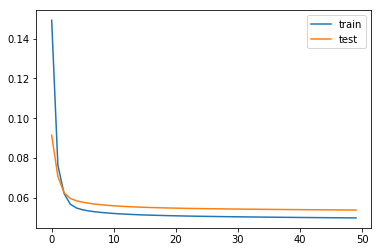

In [145]:
#fit
history = model.fit(xtrain, ytrain, nb_epoch=50, batch_size=128, validation_data=(xtest,ytest), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluation

We reshape our variables to shapes we're more familiar with

In [146]:
y_pred = model.predict(xtest)
xtest = xtest.reshape((xtest.shape[0], xtest.shape[2])) #reshaping it back

In [147]:
xtest.shape

(2525, 17)

We have to go back to our scaling model to expand our arrays back up to check the rmse. 

When we first scaled the dataset, the X and y variables were together so we must join them back up when we inverse scale. 

In [148]:
#inver scaling to forecast
y_pred_inv = concatenate((xtest,y_pred), axis=1)

y_pred_inv = MinMax.inverse_transform(y_pred_inv)
y_pred_inv = y_pred_inv[:,-1]
print(y_pred_inv.shape)

(2525,)


The same process is repeated for our test variable. It is added back and scaled up and separated again to evaluate

In [149]:
#inver scaling for truth value
ytest = ytest.reshape((len(ytest),1))
y_inv = concatenate((xtest,ytest), axis=1)
y_inv = MinMax.inverse_transform(y_inv)
y_inv = y_inv[:,-1]
print(y_inv.shape)

(2525,)


In [150]:
y_pred_inv

array([1071.15481138, 1314.26640034, 1053.85673523, ..., 1065.87261438,
       1003.56307745, 1130.34979105])

In [151]:
y_inv

array([ 834., 1453.,  843., ...,  726., -200., 1349.])

In [152]:
rmse = sqrt(mean_squared_error(y_inv, y_pred_inv))

In [153]:
rmse

259.88046579380625

The LSTM has a worse performance in the end! We can just keep this separate as it was fun and insightful to compare. 